# AI Explanations: Explaining a tabular data model


## Overview

In this tutorial we will perform the following steps:

1. Build and train a Keras model.
1. Export the Keras model as a TF 1 SavedModel and deploy the model on Cloud AI Platform.
1. Compute explainations for our model's predictions using Explainable AI on Cloud AI Platform.

### Dataset

The dataset used for this tutorial was created from a BigQuery Public Dataset: [NYC 2018 Yellow Taxi data](https://console.cloud.google.com/bigquery?filter=solution-type:dataset&q=nyc%20taxi&id=e4902dee-0577-42a0-ac7c-436c04ea50b6&subtask=details&subtaskValue=city-of-new-york%2Fnyc-tlc-trips&project=michaelabel-gcp-training&authuser=1&subtaskIndex=3). 

### Objective

The goal is to train a model using the Keras Sequential API that predicts how much a customer is compelled to pay (fares + tolls) for a taxi ride given the pickup location, dropoff location, the day of the week, and the hour of the day.

This tutorial focuses more on deploying the model to AI Explanations than on the design of the model itself. We will be using preprocessed data for this lab. If you wish to know more about the data and how it was preprocessed please see this [notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/01_bigquery/c_extract_and_benchmark.ipynb).


### Setup

In [1]:
import os

PROJECT_ID = "dougkelly-sandbox" # TODO: your PROJECT_ID here.
os.environ["PROJECT_ID"] = PROJECT_ID

In [5]:
BUCKET_NAME = "xai-labs" # TODO: your BUCKET_NAME here. 
REGION = "us-central1"

os.environ['BUCKET_NAME'] = BUCKET_NAME
os.environ['REGION'] = REGION

Run the following cell to create your Cloud Storage bucket if it does not already exist.

In [6]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET_NAME}/)

if [ -n "$exists" ]; then
   echo -e "Bucket gs://${BUCKET_NAME} already exists."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET_NAME}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

Bucket gs://xai-labs already exists.


#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, we create a timestamp for each instance session, and append onto the name of resources which will be created in this tutorial.

In [7]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Import libraries

Import the libraries for this tutorial. This tutorial has been tested with **TensorFlow versions 2.3**.

In [8]:
import tensorflow as tf
import pandas as pd

# should be >= 2.1
print("Tensorflow version " + tf.__version__)
if tf.__version__ < "2.1":
    raise Exception("TF 2.1 or greater is required")

!pip install explainable-ai-sdk
import explainable_ai_sdk

Tensorflow version 2.3.2


## Download and preprocess the data

In this section you'll download the data to train your model from a public GCS bucket. The original data is from the BigQuery datasets linked above. For your convenience, we've joined the London bike and NOAA weather tables, done some preprocessing, and provided a subset of that dataset here.


In [9]:
# Copy the data to your notebook instance
! gsutil cp 'gs://explanations_sample_data/bike-data.csv' ./

Copying gs://explanations_sample_data/bike-data.csv...
| [1 files][265.3 MiB/265.3 MiB]                                                
Operation completed over 1 objects/265.3 MiB.                                    


### Read the data with Pandas

You'll use Pandas to read the data into a `DataFrame` and then do some additional pre-processing.

In [10]:
data = pd.read_csv('bike-data.csv')

# Shuffle the data
data = data.sample(frac=1, random_state=2)

# Drop rows with null values
data = data[data['wdsp'] != 999.9]
data = data[data['dewp'] != 9999.9]

# Rename some columns for readability
data = data.rename(columns={'day_of_week': 'weekday'})
data = data.rename(columns={'max': 'max_temp'})
data = data.rename(columns={'dewp': 'dew_point'})

# Drop columns you won't use to train this model
data = data.drop(columns=['start_station_name', 'end_station_name', 'bike_id', 'snow_ice_pellets'])

# Convert trip duration from seconds to minutes so it's easier to understand
data['duration'] = data['duration'].apply(lambda x: float(x / 60))

In [11]:
# Preview the first 5 rows of training data
data.head()

,start_hr,weekday,euclidean,temp,dew_point,wdsp,max_temp,fog,prcp,rain_drizzle,duration
1559391,21,4,582.724880,54.7,46.2,0.0,56.3,0,0.00,0,22.0
1881386,16,2,2358.922742,57.1,48.2,0.0,64.9,0,0.00,0,12.0
703461,23,1,766.066253,69.2,51.6,0.0,80.4,0,0.00,0,12.0
1688076,9,5,2271.877229,52.5,45.4,0.0,63.3,0,0.02,0,13.0
2079007,14,7,2476.718116,50.3,43.5,0.0,56.1,0,0.01,0,28.0


Next, you will separate the data into features ('data') and labels ('labels').

In [12]:
# Save duration to its own DataFrame and remove it from the original DataFrame
labels = data['duration']
data = data.drop(columns=['duration'])

### Split data into train and test sets

You'll split your data into train and test sets using an 80 / 20 train / test split.

In [13]:
# Use 80/20 train/test split
train_size = int(len(data) * .8)
print("Train size: %d" % train_size)
print("Test size: %d" % (len(data) - train_size))

# Split your data into train and test sets
train_data = data[:train_size]
train_labels = labels[:train_size]

test_data = data[train_size:]
test_labels = labels[train_size:]

Train size: 757363
Test size: 189341


## Build, train, and evaluate our model with Keras 

This section shows how to build, train, evaluate, and get local predictions from a model by using the Keras [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). The model will takes your 10 features as input and predict the trip duration in minutes.

In [14]:
# Build your model
model = tf.keras.Sequential(name="bike_predict")
model.add(tf.keras.layers.Dense(64, input_dim=len(train_data.iloc[0]), activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [15]:
# Compile the model and see a summary
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)
model.summary()

Model: "bike_predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


### Create an input data pipeline with tf.data

Per best practices, we will use `tf.Data` to create our input data pipeline. Our data is all in an in-memory dataframe, so we will use `tf.data.Dataset.from_tensor_slices` to create our pipeline.

In [16]:
batch_size = 256
epochs = 3

input_train = tf.data.Dataset.from_tensor_slices(train_data)
output_train = tf.data.Dataset.from_tensor_slices(train_labels)
input_train = input_train.batch(batch_size).repeat()
output_train = output_train.batch(batch_size).repeat()
train_dataset = tf.data.Dataset.zip((input_train, output_train))

### Train the model

Now we train the model. We will specify a number of epochs which to train the model and tell the model how many steps to expect per epoch.

In [17]:
# This will take about a minute to run
# To keep training time short, you're not using the full dataset
model.fit(train_dataset, steps_per_epoch=train_size // batch_size, epochs=epochs)

Epoch 1/3
2958/2958 [==============================] - 8s 3ms/step - loss: 1.1347
Epoch 2/3
2958/2958 [==============================] - 8s 3ms/step - loss: 0.7168
Epoch 3/3
2958/2958 [==============================] - 8s 3ms/step - loss: 0.3618


### Evaluate the trained model locally

In [18]:
# Run evaluation
results = model.evaluate(test_data, test_labels)
print(results)

5917/5917 [==============================] - 10s 2ms/step - loss: 0.3506
0.35064929723739624


In [19]:
# Send test instances to model for prediction
predict = model.predict(test_data[:5])

In [20]:
# Preview predictions on the first 5 examples from your test dataset
for i, val in enumerate(predict):
    print('Predicted duration: {}'.format(round(val[0])))
    print('Actual duration: {} \n'.format(test_labels.iloc[i]))

Predicted duration: 16.0
Actual duration: 22.0 

Predicted duration: 24.0
Actual duration: 31.0 

Predicted duration: 24.0
Actual duration: 23.0 

Predicted duration: 15.0
Actual duration: 14.0 

Predicted duration: 11.0
Actual duration: 9.0 



## Export the model as a TF 2.x SavedModel

When using TensorFlow 2.x, you export the model as a `SavedModel` and load it into Cloud Storage. 

In [21]:
export_path = 'gs://' + BUCKET_NAME + '/explanations/mymodel'
model.save(export_path)
print(export_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: gs://xai-labs/explanations/mymodel/assets
gs://xai-labs/explanations/mymodel


Use TensorFlow's `saved_model_cli` to inspect the model's SignatureDef. We'll use this information when we deploy our model to AI Explanations in the next section.

In [22]:
! saved_model_cli show --dir $export_path --all

2021-05-02 20:56:21.526380: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dense_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: serving_default_dense_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/s

## Deploy the model to AI Explanations

In order to deploy the model to Explanations, you need to generate an `explanations_metadata.json` file and upload this to the Cloud Storage bucket with your SavedModel. Then you'll deploy the model using `gcloud`.

### Prepare explanation metadata

In order to deploy this model to AI Explanations, you need to create an explanation_metadata.json file with information about your model inputs, outputs, and baseline. You can use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to generate most of the fields. 

The value for `input_baselines` tells the explanations service what the baseline input should be for your model. Here you're using the median for all of your input features. That means the baseline prediction for this model will be the trip duration your model predicts for the median of each feature in your dataset. 

Since this model accepts a single numpy array with all numerical feature, you can optionally pass an `index_feature_mapping` list to AI Explanations to make the API response easier to parse. When you provide a list of feature names via this parameter, the service will return a key / value mapping of each feature with its corresponding attribution value.

In [23]:
# Print the names of your tensors
print('Model input tensor: ', model.input.name)
print('Model output tensor: ', model.output.name)

Model input tensor:  dense_input:0
Model output tensor:  dense_2/BiasAdd:0


In [24]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
builder = SavedModelMetadataBuilder(export_path)
builder.set_numeric_metadata(
    model.input.name.split(':')[0],
    input_baselines=[train_data.median().values.tolist()],
    index_feature_mapping=train_data.columns.tolist()
)
builder.save_metadata(export_path)

Since this is a regression model (predicting a numerical value), the baseline prediction will be the same for every example we send to the model. If this were instead a classification model, each class would have a different baseline prediction.

### Create the model

In [25]:
import datetime
MODEL = 'bike' + datetime.datetime.now().strftime("%d%m%Y%H%M%S")

In [26]:
# Create the model if it doesn't exist yet (you only need to run this once)
! gcloud ai-platform models create $MODEL --enable-logging --region=$REGION

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/dougkelly-sandbox/models/bike02052021205921].


### Create the model version 

Creating the version will take ~5-10 minutes. Note that your first deploy could take longer.

In [27]:
# Each time you create a version the name should be unique
VERSION = 'v1'

In [28]:
# Create the version with gcloud
explain_method = 'integrated-gradients'
! gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.1 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method $explain_method \
--num-integral-steps 25 \
--region $REGION

Using endpoint [https://us-central1-ml.googleapis.com/]
Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
Creating version (this might take a few minutes)......done.                    


In [29]:
# Make sure the model deployed correctly. State should be `READY` in the following log
! gcloud ai-platform versions describe $VERSION --model $MODEL --region $REGION

Using endpoint [https://us-central1-ml.googleapis.com/]
createTime: '2021-05-02T21:01:01Z'
deploymentUri: gs://xai-labs/explanations/mymodel
etag: uWO5ariQHFM=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
machineType: n1-standard-4
name: projects/dougkelly-sandbox/models/bike02052021205921/versions/v1
pythonVersion: '3.7'
runtimeVersion: '2.1'
state: READY


## Get predictions and explanations

Now that your model is deployed, you can use the AI Platform Prediction API to get feature attributions. You'll pass it a single test example here and see which features were most important in the model's prediction. Here you'll use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to get your prediction and explanation. You can also use `gcloud`.

### Format your explanation request

To make your AI Explanations request, you need to create a JSON object with your test data for prediction.

In [34]:
# Format data for prediction to your model
prediction_json = {model.input.name.split(':')[0]: test_data.iloc[0].values.tolist()}

### Send the explain request

You can use the Explainable AI SDK to send explanation requests to your deployed model.

In [35]:
remote_ig_model = explainable_ai_sdk.load_model_from_ai_platform(project=PROJECT_ID, 
                                                                 model=MODEL, 
                                                                 version=VERSION,
                                                                 region=REGION)
ig_response = remote_ig_model.explain([prediction_json])

### Understanding the explanations response

First, let's look at the trip duration your model predicted and compare it to the actual value.

In [36]:
attr = ig_response[0].get_attribution()

predicted = round(attr.example_score, 2)
print('Predicted duration: ' + str(predicted) + ' minutes')
print('Actual duration: ' + str(test_labels.iloc[0]) + ' minutes')

Predicted duration: 16.26 minutes
Actual duration: 22.0 minutes


Next let's look at the feature attributions for this particular example. Positive attribution values mean a particular feature pushed your model prediction up by that amount, and vice versa for negative attribution values.

Label Index 0
Example Score: 16.2637
Baseline Score: 12.9180
Approximation Error: 0.0000


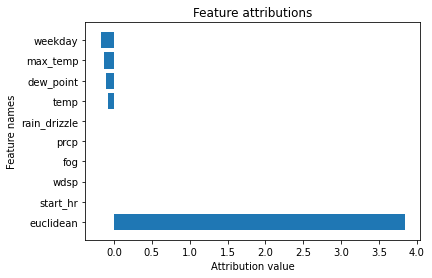

In [37]:
ig_response[0].visualize_attributions()

## Check your explanations and baselines

To better make sense of the feature attributions you're getting, you should compare them with your model's baseline. In most cases, the sum of your attribution values + the baseline should be very close to your model's predicted value for each input. Also note that for regression models, the `baseline_score` returned from AI Explanations will be the same for each example sent to your model. For classification models, each class will have its own baseline.

In this section you'll send 10 test examples to your model for prediction in order to compare the feature attributions with the baseline. Then you'll run each test example's attributions through two sanity checks in the `sanity_check_explanations` method.

In [38]:
# Prepare 10 test examples to your model for prediction
pred_batch = []
for i in range(10):
    pred_batch.append({model.input.name.split(':')[0]: test_data.iloc[i].values.tolist()})

In [39]:
test_response = remote_ig_model.explain(pred_batch)

In the function below you perform two sanity checks for models using Integrated Gradient (IG) explanations and one sanity check for models using Sampled Shapley.

In [40]:
def sanity_check_explanations(example, mean_tgt_value=None, variance_tgt_value=None):
    passed_test = 0
    total_test = 1
    # `attributions` is a dict where keys are the feature names
    # and values are the feature attributions for each feature
    attr = example.get_attribution()
    baseline_score = attr.baseline_score
    # sum_with_baseline = np.sum(attribution_vals) + baseline_score
    predicted_val = attr.example_score

    # Sanity check 1
    # The prediction at the input is equal to that at the baseline.
    #  Please use a different baseline. Some suggestions are: random input, training
    #  set mean.
    if abs(predicted_val - baseline_score) <= 0.05:
        print('Warning: example score and baseline score are too close.')
        print('You might not get attributions.')
    else:
        passed_test += 1

    # Sanity check 2 (only for models using Integrated Gradient explanations)
    # Ideally, the sum of the integrated gradients must be equal to the difference
    # in the prediction probability at the input and baseline. Any discrepency in
    # these two values is due to the errors in approximating the integral.
    if explain_method == 'integrated-gradients':
        total_test += 1
        want_integral = predicted_val - baseline_score
        got_integral = sum(attr.post_processed_attributions.values())
        if abs(want_integral - got_integral) / abs(want_integral) > 0.05:
            print('Warning: Integral approximation error exceeds 5%.')
            print('Please try increasing the number of integrated gradient steps.')
        else:
            passed_test += 1

    print(passed_test, ' out of ', total_test, ' sanity checks passed.')

In [41]:
for response in test_response:
    sanity_check_explanations(response)

2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.


## Understanding AI Explanations with the What-If Tool

In this section you'll use the [What-If Tool](https://pair-code.github.io/what-if-tool/) to better understand how your model is making predictions. See the cell below the What-if Tool for visualization ideas.

The What-If-Tool expects data with keys for each feature name, but your model expects a flat list. The functions below convert data to the format required by the What-If Tool.

In [42]:
# This is the number of data points you'll send to the What-if Tool
WHAT_IF_TOOL_SIZE = 500

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


def create_list(ex_dict):
    new_list = []
    for i in feature_names:
        new_list.append(ex_dict[i])
    return new_list


def example_dict_to_input(example_dict):
    return {'dense_input': create_list(example_dict)}


from collections import OrderedDict
wit_data = test_data.iloc[:WHAT_IF_TOOL_SIZE].copy()
wit_data['duration'] = test_labels[:WHAT_IF_TOOL_SIZE]
wit_data_dict = wit_data.to_dict(orient='records', into=OrderedDict)

In [43]:
config_builder = WitConfigBuilder(
    wit_data_dict
).set_ai_platform_model(
    PROJECT_ID,
    MODEL,
    VERSION,
    adjust_example=example_dict_to_input
).set_target_feature('duration').set_model_type('regression')

WitWidget(config_builder)

WitWidget(config={'model_type': 'regression', 'label_vocab': [], 'uses_json_input': True, 'inference_address':…

### What-If Tool visualization ideas

On the x-axis, you'll see the predicted trip duration for the test inputs you passed to the What-If Tool. Each circle represents one of your test examples. If you click on a circle, you'll be able to see the feature values for that example along with the attribution values for each feature. 

* You can edit individual feature values and re-run prediction directly within the What-If Tool. Try changing `distance`, click **Run inference** and see how that affects the model's prediction
* You can sort features for an individual example by their attribution value, try changing the sort from the attributions dropdown
* The What-If Tool also lets you create custom visualizations. You can do this by changing the values in the dropdown menus above the scatter plot visualization. For example, you can sort data points by inference error, or by their similarity to a single datapoint.

## Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Alternatively, you can clean up individual resources by running the following
commands:

In [ ]:
# Delete model version resource
! gcloud ai-platform versions delete $VERSION --quiet --model $MODEL

# Delete model resource
! gcloud ai-platform models delete $MODEL --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r gs://$BUCKET_NAME

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

To learn more about AI Explanations or the What-if Tool, check out the resources here.

* [AI Explanations documentation](cloud.google.com/ml-engine/docs/ai-explanations)
* [Documentation for using the What-if Tool with Cloud AI Platform models ](https://cloud.google.com/ml-engine/docs/using-what-if-tool) 
* [What-If Tool documentation and demos](https://pair-code.github.io/what-if-tool/)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)